## Imports

In [1]:
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
import pandas as pd
import pickle
import sqlite3

## Read Original Data

In [2]:
con = sqlite3.connect('../data/nfts.sqlite')
cur = con.cursor()

## List All Available Tables

In [3]:
query = cur.execute("""SELECT * 
FROM sqlite_master 
WHERE type='table'""")
cols = [column[0] for column in query.description]
results = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
results

,type,name,tbl_name,rootpage,sql
0,table,nfts,nfts,2,CREATE TABLE nfts\n (\n address TEXT...
1,table,checkpoint,checkpoint,5,CREATE TABLE checkpoint\n (\n event_...
2,table,mints,mints,6,CREATE TABLE mints\n (\n event_id TE...
3,table,transfers,transfers,8,CREATE TABLE transfers\n (\n event_i...
4,table,transfer_values_quartile_10_distribution_per_a...,transfer_values_quartile_10_distribution_per_a...,10,CREATE TABLE transfer_values_quartile_10_distr...
5,table,current_owners,current_owners,11,CREATE TABLE current_owners(\n nft_address TE...
6,table,current_market_values,current_market_values,12,CREATE TABLE current_market_values(\n nft_add...
7,table,market_values_distribution,market_values_distribution,13,CREATE TABLE market_values_distribution(\n ad...
8,table,transfer_statistics_by_address,transfer_statistics_by_address,14,CREATE TABLE transfer_statistics_by_address(\n...
9,table,transfer_values_quantile_10_distribution_per_a...,transfer_values_quantile_10_distribution_per_a...,15,CREATE TABLE transfer_values_quantile_10_distr...


## Union All Transactions

In [4]:
# mints: 6667282
# transfers: 4514729
# combined: 11182011
query = cur.execute("""
SELECT *, 'mint' AS activity_type
FROM mints
""")
cols = [column[0] for column in query.description]
mints_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
mints_df.head()

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp,activity_type
0,6c6d226e-2096-4b50-ac3f-f7078ca3a0c2,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,3223,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933,mint
1,263c923f-4db9-4d81-a547-27e1fe5ec405,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,5077,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933,mint
2,8baa8502-42f9-453e-824a-ad504045c9c5,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,5070,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933,mint
3,364ee658-ff31-4d0a-a7a7-60d3d7822772,0xe47ac62111db3a6de2957394944501feb7d55cbef00a...,12936415,0x02AA731631c6D7F8241d74F906f5b51724Ab98F8,3757,0x0000000000000000000000000000000000000000,0x8D745Fb3311cC86ED52C177dA0d039C1862F3e13,0.000000e+00,1627776933,mint
4,58d3adc3-03d2-4e7b-b02c-47957c1f5752,0xd44be17c0298717ce001843069b0a2ca08b577fa2b33...,12936414,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,3252202771441387673917605047769619801375983664...,0x0000000000000000000000000000000000000000,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,2.251726e+15,1627776925,mint


In [5]:
query = cur.execute("""
SELECT *, 'transfer' as activity_type
FROM transfers
""")
cols = [column[0] for column in query.description]
transfers_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
transfers_df.head()

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp,activity_type
0,cd816651-56b2-4ed9-887c-c83de732428d,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,6682934142305278177002530107138320246486863356...,0x25f1d709b329C7349b8209851E90eFa3a7f60178,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,transfer
1,82cc5228-eb80-4e0d-9f6f-e644dec3ab06,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1198507443711741845273832738859307575893198744...,0x0737E7162C88E9FBB963334e4Bfe6e97447fF811,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,transfer
2,6e1f9cc4-d1df-4a6b-972d-a20765beb326,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1541220344281436903042142177888467401468454835...,0xA0fEc186c4b3FAd39ca373dFdd52E79C2495F2c3,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,transfer
3,43dc27a7-a72d-4894-809c-e868de05f7ee,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,7993840355029527745913866651030234226423689128...,0x90bE22069560A9bAd99543B4A922d1FE34Ae84E9,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,transfer
4,47b7839b-9b87-442d-b2c1-9ebedcad8e06,0x0c73daad5e6946e6b2f1374846d6ba3025d6e6a2569f...,12936373,0x629A673A8242c2AC4B7B8C5D8735fbeac21A6205,1123719749142984581497870712442861055686734521...,0xA8E9C42Ebb915EeEC5080B7Bcc5D844475595091,0xC69b4c6fFDBaF843A0d0588c99E3C67f27069BEa,0.0,1627776481,transfer


In [6]:
transactions_df = pd.concat([mints_df, transfers_df])
transactions_df.shape

(11182011, 10)

In [7]:
transactions_df = transactions_df.sort_values(by=['timestamp'], ascending=[True])
transactions_df.head()

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp,activity_type
5864146,1b95facf-d43a-4873-a137-dcb552d0a952,0x765644e14b4b24182a59ce9a6f9a22e7b0f5828030c0...,12150245,0x1c903a2F35Fb7c6dC1792dAeC11c033f8B222D5B,19600010002,0x0000000000000000000000000000000000000000,0xE052113bd7D7700d623414a0a4585BCaE754E9d5,0.000000e+00,1617235206,mint
5864147,b88cd541-bd5e-46d4-8eb2-ca2e0e3f2c95,0x85a0f4057a63dfee3e0af93eb53d3788026c542772ce...,12150245,0xbfD1708302137109175907bA0BFba833C43C4c3f,19300030090,0x0000000000000000000000000000000000000000,0xE052113bd7D7700d623414a0a4585BCaE754E9d5,0.000000e+00,1617235206,mint
5864142,7a4c9029-0c6c-4f53-b60f-335fb0ce3ffe,0x40f4312461a1868a169a5dd16e44856e5e778f2a1b5b...,12150246,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,2067216718446828862151509780737619171783478638...,0x0000000000000000000000000000000000000000,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,5.749535e+15,1617235214,mint
5864143,3030690a-6e31-496f-9478-c01767486b40,0xf11ff0b3142176bbd2f014cddc3e9abab73a8fce5ea5...,12150246,0xa7d8d9ef8D8Ce8992Df33D8b8CF4Aebabd5bD270,37000182,0x0000000000000000000000000000000000000000,0x34477Ab85120779e938d63A5969bDcEB0C08Bb0d,1.000000e+17,1617235214,mint
5864144,2b14bb65-bff0-409b-bd07-950f1d4c85dd,0x595212d35a1cf0510c4d5f464914952411d1bbc5084b...,12150246,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,17063,0x0000000000000000000000000000000000000000,0x35a031faeE77689544933e1372E2aa75a8DeBe9f,0.000000e+00,1617235214,mint


In [8]:
transactions_df['token_transaction_order'] = transactions_df.groupby(['nft_address','token_id']).cumcount()+1

In [ ]:
# transactions_df.to_csv('../data/transactions.csv', index=False)
# transactions_df = pd.read_csv('../data/transactions.csv')

In [ ]:
# transactions_df[transactions_df["transaction_value"] == 0.0]

# Questions

In [9]:
def get_results(cur: sqlite3.Cursor = cur, statement: str = '') -> pd.DataFrame:
    '''
    Returns results from sqlite query, in the form of a pandas dataframe.
    '''
    query = cur.execute(statement)
    cols = [col[0] for col in query.description]
    df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
    return df

### 1. WHO made the most eth?

#### Query getting transaction deltas

In [ ]:
# who has made the most money (takes 3min 16sec)
statement = '''
with
    mints_and_transfers as (
        select
            *
            , 'mint' as activity
        from mints
        union all
        select
            *
            , 'transfer' as activity
        from transfers
    )
    , nfts_with_order as (
        select
            transaction_hash
            , nft_address
            , token_id
            , activity
            , from_address
            , to_address
            , transaction_value
            , timestamp
            , row_number() over (
                partition by nft_address, token_id
                order by timestamp asc
            ) as row_num
        from mints_and_transfers
    )
    , starts_join_ends as (
        select
            nwo1.transaction_hash
            , nwo1.nft_address
            , nwo1.token_id
            , nwo1.activity as start_activity
            , nwo1.to_address as start_address
            , nwo1.transaction_value as start_value
            , nwo1.timestamp as start_timestamp
            , nwo1.row_num as start_row
            , ifnull(nwo2.activity, 'hold') as end_activity
            , ifnull(nwo2.to_address, nwo1.to_address) as end_address
            , ifnull(nwo2.transaction_value, cmv.market_value) as end_value
            , ifnull(nwo2.timestamp, 1632586540) as end_timestamp
            , ifnull(nwo2.row_num, nwo1.row_num) as end_row
        from nfts_with_order as nwo1
        left join nfts_with_order as nwo2 on 
            nwo1.nft_address = nwo2.nft_address
            and nwo1.token_id = nwo2.token_id
            and nwo1.row_num + 1 = nwo2.row_num
        left join current_market_values as cmv on
            nwo1.nft_address = cmv.nft_address
            and nwo1.token_id = cmv.token_id
    )
    , pairs_with_deltas as (
        select
            *
            , end_value - start_value as delta_value
            , julianday(end_timestamp, 'unixepoch') - julianday(start_timestamp, 'unixepoch') as delta_days
            , cast(start_row as string) || '->' || cast(end_row as string) as row_change
        from starts_join_ends
    )
select * from pairs_with_deltas
'''

df = get_results(cur, statement)
pickle.dump(df, open('../pickles/df_q1.pkl', 'wb'))
df.head()

In [10]:
# loading from pkl
df = pickle.load(open('../pickles/df_q1.pkl', 'rb'))
df.head()

,transaction_hash,nft_address,token_id,start_activity,start_address,start_value,start_timestamp,start_row,end_activity,end_address,end_value,end_timestamp,end_row,delta_value,delta_days,row_change
0,0x7c2300b8a34fc65605e045a7eef9ab4966c8de2e87bc...,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,0,mint,0xb776cAb26B9e6Be821842DC0cc0e8217489a4581,3.000000e+16,1630522006,1,hold,0xb776cAb26B9e6Be821842DC0cc0e8217489a4581,3.000000e+16,1632586540,1,0.0,23.895069,1->1
1,0x9fc3718924d43e27d6a3adc0716335cd72c70e72c4e1...,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,1,mint,0x8A73024B39A4477a5Dc43fD6360e446851AD1D28,1.500000e+17,1630523878,1,hold,0x8A73024B39A4477a5Dc43fD6360e446851AD1D28,1.500000e+17,1632586540,1,0.0,23.873403,1->1
2,0x2be3aae4638495c06b6b03800b6ebe165d11ba532a0e...,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,10,mint,0x5e5C817E9264B46cBBB980198684Ad9d14f3e0B4,1.500000e+17,1630524131,1,hold,0x5e5C817E9264B46cBBB980198684Ad9d14f3e0B4,1.500000e+17,1632586540,1,0.0,23.870475,1->1
3,0x30f16b319b1e5a7f35b370742684773af9b7fe3c5cbd...,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,11,mint,0x8376f63c13b99D3eedfA51ddd77Ff375279B3Ba0,3.000000e+16,1630524172,1,hold,0x8376f63c13b99D3eedfA51ddd77Ff375279B3Ba0,3.000000e+16,1632586540,1,0.0,23.870000,1->1
4,0xf8312cedb3f2404ea14e14396279fb55ca36399f9b77...,0x00000000000b7F8E8E8Ad148f9d53303Bfe20796,12,mint,0xb5e34552F32BA9226C987769BF6555a538510BA8,9.000000e+16,1630525084,1,hold,0xb5e34552F32BA9226C987769BF6555a538510BA8,9.000000e+16,1632586540,1,0.0,23.859444,1->1


#### Additional wrangling for top 100 "winners" and how much they made

In [11]:
# filter out the holds. else takes current market value (floor price?); if people mint free or just send to a certain account their value becomes inflated
# additionally filter out genesis address if it appears: 0x0000000000000000000000000000000000000000

# not 100% reflective of actual values
# private transactions get ignored (will use a proxy address; one transaction with token and the other with coin)

profit_df = df[df['end_activity'] != 'hold']
profit_df = profit_df[['start_address', 'delta_value']].groupby(['start_address']).sum()
profit_df = profit_df.sort_values(by=['delta_value'], ascending=[False])


In [12]:
profit_df.head(20)

,delta_value
start_address,
0xe1D29d0a39962a9a8d2A297ebe82e166F8b8EC18,1.504803e+22
0xC310e760778ECBca4C65B6C559874757A4c4Ece0,7.297544e+21
0x75D4AF89B2751d14a7774e473EfCaE3232d74C3B,5.336485e+21
0xe5d852EB21a19c1d2F04fd9E4A92cF893B95731c,4.438140e+21
0xAfd37C11f9DFEe561db31D9bAb7cEc4812BBD241,2.534500e+21
0x1DDcF25f111F5Fb653dA75aB75CE68b928C56a63,2.400000e+21
0x28d804Bf2212E220BC2B7B6252993Db8286dF07f,2.100204e+21
0x721931508DF2764fD4F70C53Da646Cb8aEd16acE,2.090781e+21
0xe0A36cE07Ea9Bd3719a03A28948d398a8a093059,1.862970e+21


In [13]:
winners_df = profit_df.head(100).copy()
winners_df['delta_value_eth'] = (winners_df['delta_value'] / 1000000000000000000) # wei to eth = 10^18
winners_df.to_csv('../data/transactions_winners_top100.csv')

In [ ]:
# winners_df = pd.read_csv('../data/transactions_winners_top100.csv')

In [14]:
winners_df.head(20)

,delta_value,delta_value_eth
start_address,,
0xe1D29d0a39962a9a8d2A297ebe82e166F8b8EC18,1.504803e+22,15048.030400
0xC310e760778ECBca4C65B6C559874757A4c4Ece0,7.297544e+21,7297.543701
0x75D4AF89B2751d14a7774e473EfCaE3232d74C3B,5.336485e+21,5336.485290
0xe5d852EB21a19c1d2F04fd9E4A92cF893B95731c,4.438140e+21,4438.140000
0xAfd37C11f9DFEe561db31D9bAb7cEc4812BBD241,2.534500e+21,2534.500000
0x1DDcF25f111F5Fb653dA75aB75CE68b928C56a63,2.400000e+21,2400.000000
0x28d804Bf2212E220BC2B7B6252993Db8286dF07f,2.100204e+21,2100.204217
0x721931508DF2764fD4F70C53Da646Cb8aEd16acE,2.090781e+21,2090.781094
0xe0A36cE07Ea9Bd3719a03A28948d398a8a093059,1.862970e+21,1862.970000


In [15]:
losers_df = profit_df.tail(100).copy()
losers_df['delta_value_eth'] = (losers_df['delta_value'] / 1000000000000000000) # wei to eth = 10^18
losers_df = losers_df.sort_values(by=['delta_value'], ascending=[True])
losers_df.to_csv('../data/transactions_losers_top100.csv')

In [ ]:
# losers_df = pd.read_csv('../data/transactions_losers_top100.csv')

In [16]:
losers_df.head(20)

,delta_value,delta_value_eth
start_address,,
0x67e9a5894D2713553cd3cBC7D034Be9F1F830D3b,-9.567964e+22,-95679.642954
0x9c5083dd4838E120Dbeac44C052179692Aa5dAC5,-3.557188e+22,-35571.880562
0x61C808D82A3Ac53231750daDc13c777b59310bD9,-3.498967e+22,-34989.665126
0x924Ec2504CC71CdbD39011B417ac5a9D3d4dFF1b,-1.735887e+22,-17358.870000
0x51346D389ec7ADf11C5b96695ef003dbb849af9A,-1.179398e+22,-11793.983600
0xdC72bd8115311209270c453D52a031773372c52F,-1.124500e+22,-11245.000000
0xd68B6e9fC4eab0f041C5D2bF1EE7c4fD87d4e99f,-1.088500e+22,-10885.000000
0x7641a5E890478Bea2bdC4CAFfF960AC4ae96886e,-7.442366e+21,-7442.365591
0x8c685C44fACB8Bf246fCb0E383CCa4Bd46634bF8,-5.990913e+21,-5990.913039


### 2. WHAT did they transact on?

#### Get winner transactions only

In [17]:
transactions_df.head()

,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp,activity_type,token_transaction_order
5864146,1b95facf-d43a-4873-a137-dcb552d0a952,0x765644e14b4b24182a59ce9a6f9a22e7b0f5828030c0...,12150245,0x1c903a2F35Fb7c6dC1792dAeC11c033f8B222D5B,19600010002,0x0000000000000000000000000000000000000000,0xE052113bd7D7700d623414a0a4585BCaE754E9d5,0.000000e+00,1617235206,mint,1
5864147,b88cd541-bd5e-46d4-8eb2-ca2e0e3f2c95,0x85a0f4057a63dfee3e0af93eb53d3788026c542772ce...,12150245,0xbfD1708302137109175907bA0BFba833C43C4c3f,19300030090,0x0000000000000000000000000000000000000000,0xE052113bd7D7700d623414a0a4585BCaE754E9d5,0.000000e+00,1617235206,mint,1
5864142,7a4c9029-0c6c-4f53-b60f-335fb0ce3ffe,0x40f4312461a1868a169a5dd16e44856e5e778f2a1b5b...,12150246,0x57f1887a8BF19b14fC0dF6Fd9B2acc9Af147eA85,2067216718446828862151509780737619171783478638...,0x0000000000000000000000000000000000000000,0x283Af0B28c62C092C9727F1Ee09c02CA627EB7F5,5.749535e+15,1617235214,mint,1
5864143,3030690a-6e31-496f-9478-c01767486b40,0xf11ff0b3142176bbd2f014cddc3e9abab73a8fce5ea5...,12150246,0xa7d8d9ef8D8Ce8992Df33D8b8CF4Aebabd5bD270,37000182,0x0000000000000000000000000000000000000000,0x34477Ab85120779e938d63A5969bDcEB0C08Bb0d,1.000000e+17,1617235214,mint,1
5864144,2b14bb65-bff0-409b-bd07-950f1d4c85dd,0x595212d35a1cf0510c4d5f464914952411d1bbc5084b...,12150246,0x3B3ee1931Dc30C1957379FAc9aba94D1C48a5405,17063,0x0000000000000000000000000000000000000000,0x35a031faeE77689544933e1372E2aa75a8DeBe9f,0.000000e+00,1617235214,mint,1


In [18]:
winner_from_tx = winners_df.merge(transactions_df, left_on='start_address', right_on='from_address', how='left')
# winner_from_tx.head()

In [19]:
winner_to_tx = winners_df.merge(transactions_df, left_on='start_address', right_on='to_address', how='left')
# winner_to_tx.head()

In [20]:
# who are the winners - how much have they made
# add notes to grain of salt on profits - would have to look at more than erc721 transaction
winner_transactions_df = pd.concat([winner_from_tx, winner_to_tx])
winner_transactions_df = winner_transactions_df.sort_values(by=['timestamp'], ascending=[True])
winner_transactions_df.to_csv('../data/transactions_winners_top100.csv', index=False)

In [21]:
winner_transactions_df.head()

,delta_value,delta_value_eth,event_id,transaction_hash,block_number,nft_address,token_id,from_address,to_address,transaction_value,timestamp,activity_type,token_transaction_order
79054,5.232585e+20,523.258512,94f23fba-eca7-40b1-ad7a-1589f0f00ea7,0xebbbe2fbde45181f184027fc06c1f7f3e86d1822a8f4...,12150397,0xc170384371494b2A8f6ba20F4d085c4DDe763d96,100010057,0x8b51C1Ba09EE33e7649CAc62cCb6d0f410F5647A,0x4bbb41F61fFfc1Bbe65a2aa192C65281E16eA758,0.000000e+00,1617237481,transfer,1
21182,1.428159e+21,1428.158791,5c434cd7-aebd-4d77-80fb-32188601dc43,0xbbe4b06856dedaa65f54ebb7f2c9677ee3b0bd5656c0...,12150469,0x06012c8cf97BEaD5deAe237070F9587f8E7A266d,1817088,0xb1690C08E213a35Ed9bAb7B318DE14420FB57d8C,0x7f2A18b35024cf283069Eb5394BF4e2567b2976d,5.000000e+15,1617238313,transfer,1
21181,1.428159e+21,1428.158791,98ab53b7-1240-4b28-8ccc-24d8b481e387,0x85fc52754ee2b89e8c834ad3a996fdaf65df8922771d...,12150469,0x06012c8cf97BEaD5deAe237070F9587f8E7A266d,1824697,0xb1690C08E213a35Ed9bAb7B318DE14420FB57d8C,0x7f2A18b35024cf283069Eb5394BF4e2567b2976d,5.000000e+15,1617238313,transfer,1
21183,1.428159e+21,1428.158791,d21c61ec-b856-492f-ba87-5c72af04faf2,0x9b43d1ec4ccf526d9cd57239a08387edbfafe95a9812...,12150515,0x06012c8cf97BEaD5deAe237070F9587f8E7A266d,920370,0xb1690C08E213a35Ed9bAb7B318DE14420FB57d8C,0x15Bd6DA4D9137aA93C2ee536e1ea1a4dc5e6051E,6.000000e+15,1617238847,transfer,1
21184,1.428159e+21,1428.158791,a148a367-f975-41e1-ad01-474a0d54d07a,0x525ab5688a82c2f6705412c689b77beb484c43bc228a...,12150524,0x06012c8cf97BEaD5deAe237070F9587f8E7A266d,1194138,0xb1690C08E213a35Ed9bAb7B318DE14420FB57d8C,0x15Bd6DA4D9137aA93C2ee536e1ea1a4dc5e6051E,6.000000e+15,1617238951,transfer,1


In [22]:
# what are they trading
temp_winner_transactions_df = winner_transactions_df.copy()
temp_winner_transactions_df['count'] = 1
temp_winner_transactions_df = temp_winner_transactions_df[['nft_address', 'delta_value', 'delta_value_eth', 'count']].groupby(['nft_address']).sum()

In [23]:
# get nft collection names
query = cur.execute("""SELECT * 
FROM nfts
""")
cols = [column[0] for column in query.description]
nft_collections_df = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
nft_collections_df

,address,name,symbol
0,0xF4ee95274741437636e748DdAc70818B4ED7d043,The Doge Pound,DOGGY
1,0xba30E5F9Bb24caa003E9f2f0497Ad287FDF95623,BoredApeKennelClub,BAKC
2,0x7403AC30DE7309a0bF019cdA8EeC034a5507cbB3,Characters,CHAR
3,0x511372B44231a31527025a3D273C1dc0a83D77aF,Maps Restored,MAP
4,0x2E956Ed3D7337F4Ed4316A6e8F2EdF74BF84bb54,Neon Junkies,JUNKIES
...,...,...,...
9383,0x848433E170d7b253e8004415643260f18e36fA40,Fredrick and Penny,FNPBJ
9384,0xb5dc78d106cb4540ca945DC1fabC63845198f3F0,SH Minter,SH
9385,0x053bf84359415542E9d65138d1bC0dD0d01e10F7,NFT - 3,NFT3
9386,0xc1a8621eFdeF8E2173435Af416ac18D858ECaF49,Pedro Ferreira,PF


In [24]:
temp_winner_transactions_df = temp_winner_transactions_df.merge(nft_collections_df, left_on='nft_address', right_on='address', how='left')
temp_winner_transactions_df

,delta_value,delta_value_eth,count,address,name,symbol
0,2.623033e+21,2623.032816,2,0x000E49C87d2874431567d38FF9548890aB39BAac,Goobers,GOOBERS
1,1.447071e+23,144707.062329,182,0x004f5683e183908D0f6b688239e3e2D5bbb066CA,Hall Of Fame Goat Lodge,HOFG
2,9.122781e+23,912278.143317,408,0x00C396383400a1EF2eB401052dBF5d989B2da481,Cypher City,CYPHER
3,1.114855e+22,11148.551754,16,0x00CCc5Fe33fa66847082af413d4A8700cd7CDe16,Wen Rug Pull,WENRUGPULL
4,3.882657e+21,3882.656800,4,0x00D07C53E70338c376cF6ab2A5218d8643115084,Postereum 3,PEV3
...,...,...,...,...,...,...
1181,1.572376e+21,1572.376029,3,0xfc007068C862E69213Dc7AA817063B1803D4E941,MOONDOGS ODYSSEY,WIENERS
1182,1.504803e+22,15048.030400,1,0xfc4c87cAbfb6bF4d00e0d26D9E64B2343419db42,NessGraphics,NESS
1183,8.569751e+21,8569.750548,12,0xfd3fd9b793bAc60e7F0a9b9fB759DB3e250383cB,Ethereans,ETHRS
1184,5.241253e+20,524.125343,1,0xfd4a7C3CBd01b7111e42E3E72d28C49e11Bf7eC5,Faticorn,FATI


In [25]:
# view winner transactions by frequent nfts traded
temp_winner_transactions_df_count = temp_winner_transactions_df.sort_values(by=['count'], ascending=[False])
temp_winner_transactions_df_count.head(25)

,delta_value,delta_value_eth,count,address,name,symbol
33,5.219020e+25,5.219020e+07,36570,0x06012c8cf97BEaD5deAe237070F9587f8E7A266d,CryptoKitties,CK
705,8.960531e+25,8.960531e+07,20412,0x9a604220d37b69c09eFfCcd2E8475740773E3DaF,Spunks NFT,SPUNK
948,1.706103e+25,1.706103e+07,12018,0xa7d8d9ef8D8Ce8992Df33D8b8CF4Aebabd5bD270,Art Blocks,BLOCKS
779,7.734290e+24,7.734290e+06,4062,0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D,BoredApeYachtClub,BAYC
538,3.317924e+24,3.317924e+06,3089,0x7Bd29408f11D2bFC23c34f18275bBf23bB716Bc7,Meebits,⚇
1084,2.189159e+24,2.189159e+06,3043,0xda9f43015749056182352e9dC6D3eE0B6293D80A,EtherLambos,EL
927,3.141611e+24,3.141611e+06,2374,0xFF9C1b15B16263C61d017ee9F65C50e4AE0113D7,Loot,LOOT
675,1.109615e+25,1.109615e+07,2318,0x9759226B2F8ddEFF81583e244Ef3bd13AAA7e4A1,Purrnelopes Country Club,PCC
379,2.744303e+24,2.744303e+06,2220,0x50f5474724e0Ee42D9a4e711ccFB275809Fd6d4a,Sandbox's LANDs,LAND
546,3.160651e+24,3.160651e+06,2183,0x7EA3Cca10668B8346aeC0bf1844A49e995527c8B,CyberKongz VX,KONGZ VX


In [26]:
# view winner transactions by collections that saw the most profit
temp_winner_transactions_df_profit = temp_winner_transactions_df.sort_values(by=['delta_value'], ascending=[False])
temp_winner_transactions_df_profit.head(25)

,delta_value,delta_value_eth,count,address,name,symbol
705,8.960531e+25,8.960531e+07,20412,0x9a604220d37b69c09eFfCcd2E8475740773E3DaF,Spunks NFT,SPUNK
33,5.219020e+25,5.219020e+07,36570,0x06012c8cf97BEaD5deAe237070F9587f8E7A266d,CryptoKitties,CK
948,1.706103e+25,1.706103e+07,12018,0xa7d8d9ef8D8Ce8992Df33D8b8CF4Aebabd5bD270,Art Blocks,BLOCKS
675,1.109615e+25,1.109615e+07,2318,0x9759226B2F8ddEFF81583e244Ef3bd13AAA7e4A1,Purrnelopes Country Club,PCC
779,7.734290e+24,7.734290e+06,4062,0xBC4CA0EdA7647A8aB7C2061c2E118A18a936f13D,BoredApeYachtClub,BAYC
285,4.576624e+24,4.576624e+06,600,0x3a8778A58993bA4B941f85684D74750043A4bB5f,BullsOnTheBlock,BOTB
142,3.604783e+24,3.604783e+06,439,0x1cBB182322Aee8ce9F4F1f98d7460173ee30Af1F,Polymorphs,MORPH
384,3.595173e+24,3.595173e+06,499,0x521f9C7505005CFA19A8E5786a9c3c9c9F5e6f42,ForgottenRunesWizardsCult,WIZARDS
538,3.317924e+24,3.317924e+06,3089,0x7Bd29408f11D2bFC23c34f18275bBf23bB716Bc7,Meebits,⚇
546,3.160651e+24,3.160651e+06,2183,0x7EA3Cca10668B8346aeC0bf1844A49e995527c8B,CyberKongz VX,KONGZ VX


#### Minting vs trading profits

In [57]:
temp_winner_transactions_df2 = winner_transactions_df.copy()
temp_winner_transactions_df2['count'] = 1
temp_winner_transactions_df2 = temp_winner_transactions_df2[['activity_type', 'delta_value', 'delta_value_eth', 'count']].groupby(['activity_type']).mean()

In [58]:
temp_winner_transactions_df2
# maybe how does this compare to everyone else?

,delta_value,delta_value_eth,count
activity_type,,,
mint,2.288508e+21,2288.508137,1.0
transfer,1.937517e+21,1937.516652,1.0


#### Rando

In [31]:
query = cur.execute("""
SELECT * 
FROM transfer_statistics_by_address 
""")
cols = [column[0] for column in query.description]
results = pd.DataFrame.from_records(data = query.fetchall(), columns = cols)
results

,address,transfers_out,transfers_in
0,0x0000000000000000000000000000000000000000,0,118931
1,0x0000000000000000000000000000000000000001,1,7307
2,0x0000000000000000000000000000000000000069,0,1
3,0x00000000000000000000000000000000000000ff,0,1
4,0x0000000000000000000000000000000000001388,0,1
...,...,...,...
509572,0xfffCdadfBADFcaB4E9FEC019e382f79833C8Ed99,1,0
509573,0xfffEAAc0F337d38b61b19CDb9550c0F1Ea2E437A,3,0
509574,0xfffFa8f60d2eC6a559ef3617576ED28Bc397D360,5,4
509575,0xfffaA912b2740381eB753A03E9c13c661CeFC0ed,15,36


# When is the best time to offload (a.k.a hype window)

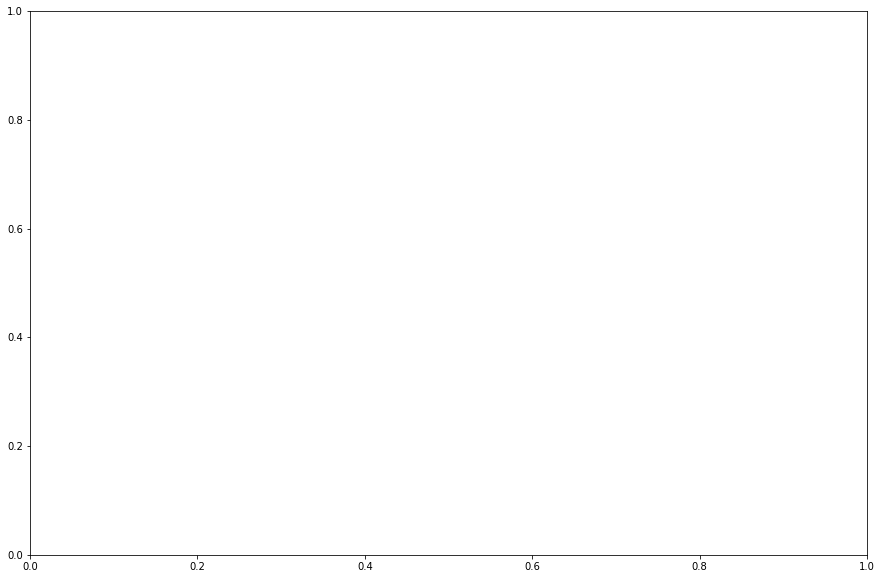

In [65]:
# average delta_value by days held - aka hype window
import math

days_held_df = df[['delta_value', 'delta_days']][df['end_activity'] == 'mint']
days_held_df.loc[:, 'delta_days_int'] = df['delta_days'].apply(math.floor)
data = days_held_df.groupby('delta_days_int')['delta_value'].rolling(14).mean()

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
ax.plot(data.index, data.values)
ax.set_ylabel('mean_delta_value')
ax.set_title('')
plt.show()

<AxesSubplot:xlabel='delta_days_int'>

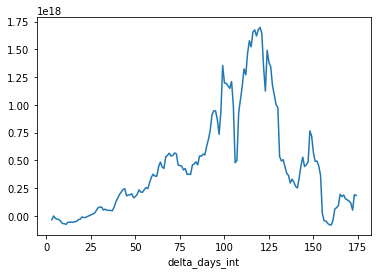

In [54]:
data.rolling(7, center = True).mean().plot()

In [63]:
days_held_df.groupby('delta_days_int')['delta_value'].rolling(14).mean()

delta_days_int         
0               32        NaN
                34        NaN
                36        NaN
                38        NaN
                40        NaN
                           ..
176             9161663   NaN
                9564001   NaN
                9880839   NaN
177             325280    NaN
                4896610   NaN
Name: delta_value, Length: 4156424, dtype: float64